## Setup

In [1]:
# Import statement
import xarray as xr
from typing import List
import cartopy.crs as ccrs
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from sklearn.feature_selection import mutual_info_regression


# Set default style to dark background because I like it better
plt.style.use("dark_background")
plt.rcParams["hatch.linewidth"] = 0.3


In [2]:
# Define useful functions
def get_wofs_all(init: int) -> xr.Dataset:
    """Read in WoFS output based on initialization time."""
    file_pattern = f"/mnt/drive2/new-wofs/{init:02d}Z/wofs_ALL*.nc"
    loaded = xr.open_mfdataset(
        file_pattern, combine="nested", concat_dim="time", chunks="auto"
    )

    if init < 6:
        start_time = f"2021-09-02 {init:02d}:00:00"
        end_time = f"2021-09-02 {init + 6:02d}:00:00"
    else:
        start_time = f"2021-09-01 {init:02d}:00:00"
        end_time = f"2021-09-02 {init - 24 + 6:02d}:00:00"

    loaded["time"] = xr.cftime_range(start_time, end_time, freq="5min")
    return loaded


def smooth(da: xr.DataArray, sigma: int = 3, axes: tuple = (1, 2)) -> xr.DataArray:
    """Apply Gaussian smoothing to the DataArray."""
    smoothed_da = da.copy()
    smoothed_da.values = gaussian_filter(da.values, sigma=sigma, axes=axes)
    smoothed_da = smoothed_da.assign_attrs(da.attrs)
    return smoothed_da


def get_mean_field(
    wofs_list: List[xr.Dataset],
    varname: str,
    start_time: str,
    end_time: str,
    init_dim: xr.DataArray,
) -> xr.DataArray:
    """
    Calculate the mean of a field (varname) for a given time slice across multiple datasets.

    Parameters:
    wofs_list (List[xr.Dataset]): List of xarray datasets.
    varname (str): Name of the variable from the Dataset to get.
    start_time (str): Start time for the time slice (format: 'YYYY-MM-DD HH:MM:SS').
    end_time (str): End time for the time slice (format: 'YYYY-MM-DD HH:MM:SS').
    init_dim (str): Name of the dimension to concatenate along.

    Returns:
    xr.DataArray: Mean variable concatenated along the specified dimension.
    """
    return xr.concat(
        [
            w[varname].sel(time=slice(start_time, end_time)).mean(dim="time")
            for w in wofs_list
        ],
        dim=init_dim,
    ).chunk({"init": -1})


def get_total_field(
    wofs_list: List[xr.Dataset],
    varname: str,
    start_time: str,
    end_time: str,
    init_dim: xr.DataArray,
) -> xr.DataArray:
    """
    Calculate the sum of a field (varname) for a given time slice across multiple datasets.

    Parameters:
    wofs_list (List[xr.Dataset]): List of xarray datasets.
    varname (str): Name of the variable from the Dataset to get.
    start_time (str): Start time for the time slice (format: 'YYYY-MM-DD HH:MM:SS').
    end_time (str): End time for the time slice (format: 'YYYY-MM-DD HH:MM:SS').
    init_dim (str): Name of the dimension to concatenate along.

    Returns:
    xr.DataArray: Summed-up variable concatenated along the specified dimension.
    """
    return xr.concat(
        [
            w[varname].sel(time=slice(start_time, end_time)).sum(dim="time")
            for w in wofs_list
        ],
        dim=init_dim,
    ).chunk({"init": -1})


def get_field(
    wofs_list: List[xr.Dataset],
    varname: str,
    start_time: str,
    end_time: str,
    init_dim: xr.DataArray,
) -> xr.DataArray:
    """
    Return a field (varname) for a given time slice across multiple datasets.

    Parameters:
    wofs_list (List[xr.Dataset]): List of xarray datasets.
    varname (str): Name of the variable from the Dataset to get.
    start_time (str): Start time for the time slice (format: 'YYYY-MM-DD HH:MM:SS').
    end_time (str): End time for the time slice (format: 'YYYY-MM-DD HH:MM:SS').
    init_dim (str): Name of the dimension to concatenate along.

    Returns:
    xr.DataArray: Summed-up variable concatenated along the specified dimension.
    """
    return xr.concat(
        [w[varname].sel(time=slice(start_time, end_time)) for w in wofs_list],
        dim=init_dim,
    ).chunk({"init": -1})


def calc_ens_sens(predictor: xr.DataArray, predictand: xr.DataArray) -> xr.DataArray:
    """
    Calculate the ensemble sensitivity of the predictand to the predictor.

    Parameters:
    predictor (xr.DataArray): DataArray housing the predictor.
    predictand (xr.DataArray): DataArray containing the predictand

    Returns:
    xr.DataArray: The ensemble sensitivity.
    """

    # Calculate the covariance
    covar = (
        (predictor - predictor.mean(dim=("init", "ne")))
        * (predictand - predictand.mean(dim=("init", "ne")))
    ).mean(dim=("init", "ne"))

    # predictor_var = ((predictor - predictor.mean(dim=("init", "ne"))) ** 2).mean(
    #     dim=("init", "ne")
    # )

    predictor_var = predictor.std(dim=("init","ne")) ** 2
    
    # Calculate sensitivity
    sens = covar / predictor_var

    return sens

def calc_theta(temp: xr.DataArray, pres: int) -> xr.DataArray:
    theta = (temp + 273.15) * (1000/pres)**0.286
    return(theta)


In [3]:
# Load in 20-23Z initializations
wofs_all = [get_wofs_all(i) for i in [20,21,22,23]]

In [4]:
# Define variables and parameters
lat = wofs_all[0].xlat.isel(time=0).squeeze().drop_vars("time")
lon = wofs_all[0].xlon.isel(time=0).squeeze().drop_vars("time")

# Set up Cartopy projection
proj = ccrs.LambertConformal(
    central_longitude=wofs_all[0].attrs["CEN_LON"],
    central_latitude=wofs_all[0].attrs["CEN_LAT"],
    standard_parallels=(30, 60),
)  # WoFS projection

# Create a DataArray for the initialization dimension
init = xr.DataArray(data=["20Z", "21Z", "22Z", "23Z"], dims="init").assign_coords(
    {"init": ["20Z", "21Z", "22Z", "23Z"]}
)

In [5]:
# Get the 01 to 02 UTC rainfall
rain12 = get_total_field(
    wofs_all, "rain", "2021-09-02 01:05:00", "2021-09-02 02:00:00", init_dim=init
)
# rain01 = get_total_field(wofs_all, "rain", "2021-09-02 00:05:00", "2021-09-02 01:00:00", init_dim=init)

# Calculate standard deviation of rainfall
std = rain12.std(dim=("init", "ne"))

# Lastly, make our area of interest where sd > 65% of max sd
aoi = std > (std.max() * 0.65)

rain12_aoi = rain12.where(aoi).mean(dim=("lat", "lon"), skipna=True)


## Data processing

In [13]:
# list of variables
vars_list = [
    "U_500",
    "U_850",
    "V_500",
    "V_850",
    "cape_ml",
    "comp_dz",
    "geo_hgt_500",
    "geo_hgt_850",
    "mslp",
    "pw",
    "temperature_850",
    "temperature_500",
]

ds = xr.merge(
    [
        get_field(wofs_all, v, "2021-09-01 23:00:00", "2021-09-02 01:00:00", init)
        for v in vars_list
    ]
).stack(run=("init", "ne"))


In [15]:
# Select the first time step and flatten the lat-lon dimensions
ds_flat = ds.isel(time=0).stack(flat=('lat', 'lon')).transpose('run', 'flat')

# Create a 2D array (run, variables * lat-lon points)
X = np.column_stack([ds_flat[var].values for var in ds_flat.data_vars])

In [24]:
# Get the rainfall data as a 1D array
y = rain12_aoi.stack(run=("ne","init")).values  # Assuming 'rainfall' is your DataArray for 1-2Z NYC rainfall

# Check for NaNs
nan_mask = ~np.isnan(X).any(axis=1) & ~np.isnan(y)
X = X[nan_mask]
y = y[nan_mask]


In [25]:
# X: Your predictor variables, y: NYC rainfall values
mi_scores = mutual_info_regression(X, y, random_state=42, n_jobs=-1) # type: ignore


In [29]:
# Assuming ds_flat has dimensions ('run', 'flat') where 'flat' = lat * lon
# and mi_scores has length equal to the total number of features (variables * lat-lon points)
n_vars = len(vars_list)
n_latlon = len(ds_flat['flat'])  # Number of lat-lon points

# Reshape the mi_scores back to (n_vars, lat, lon)
mi_scores_reshaped = mi_scores.reshape((n_vars, len(ds['lat']), len(ds['lon'])))

# Create a Dataset where each variable gets its own DataArray
mi_ds = xr.Dataset(
    {
        var: (("lat", "lon"), mi_scores_reshaped[i])
        for i, var in enumerate(vars_list)
    },
    coords={"lat": ds['lat'], "lon": ds['lon']}
)

# Now you have a Dataset where each variable is its own DataArray
print(mi_ds)


<xarray.Dataset> Size: 9MB
Dimensions:          (lat: 300, lon: 300)
Coordinates:
  * lat              (lat) int64 2kB 0 1 2 3 4 5 6 ... 294 295 296 297 298 299
  * lon              (lon) int64 2kB 0 1 2 3 4 5 6 ... 294 295 296 297 298 299
Data variables:
    U_500            (lat, lon) float64 720kB 0.0 0.0 0.0 ... 0.0157 0.01533
    U_850            (lat, lon) float64 720kB 0.04211 0.07851 ... 0.08138
    V_500            (lat, lon) float64 720kB 0.0 0.04098 ... 0.0 0.01305
    V_850            (lat, lon) float64 720kB 0.02977 0.0 0.0 ... 0.04833 0.0
    cape_ml          (lat, lon) float64 720kB 0.1355 0.07334 0.06378 ... 0.0 0.0
    comp_dz          (lat, lon) float64 720kB 1.11e-16 1.11e-16 ... 1.11e-16
    geo_hgt_500      (lat, lon) float64 720kB 0.0129 0.0 0.0 ... 0.0 0.0 0.0
    geo_hgt_850      (lat, lon) float64 720kB 0.0 0.0 0.0 ... 0.04105 0.06906
    mslp             (lat, lon) float64 720kB 1.11e-16 1.11e-16 ... 1.11e-16
    pw               (lat, lon) float64 720kB 0.0 0

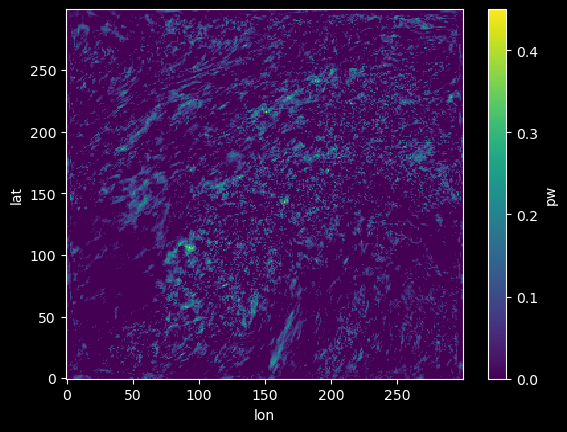

In [43]:
mi_ds..plot()

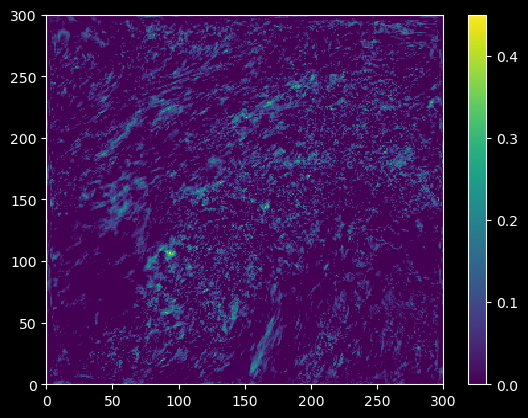

In [48]:
plt.pcolormesh(mi_scores.reshape(len(vars_list),300,300)[-3])
plt.colorbar()

In [49]:
# list of variables
vars_list = [
    "pw",
    "geo_hgt_500",
    "geo_hgt_850",
    "cape_ml",
    "temperature_500",
    "temperature_850",
    "U_850",
    "V_850",
    "mslp",
    "comp_dz",
]

ds = xr.merge(
    [
        get_field(wofs_all, v, "2021-09-01 23:00:00", "2021-09-02 01:00:00", init)
        for v in vars_list
    ]
).stack(run=("init", "ne"))

In [52]:
# Select the last time step and flatten the lat-lon dimensions
ds_flat = ds.isel(time=0).stack(flat=('lat', 'lon')).transpose('run', 'flat')

# Create a 2D array (run, variables * lat-lon points)
X = np.column_stack([ds_flat[var].values for var in ds_flat.data_vars])
# Get the rainfall data as a 1D array
y = rain12_aoi.stack(run=("ne","init")).values  # Assuming 'rainfall' is your DataArray for 1-2Z NYC rainfall
# y = rain12_aoi.values

In [53]:
from sklearn.feature_selection import mutual_info_regression

# X: Your predictor variables, y: NYC rainfall values
mi_scores = mutual_info_regression(X, y, n_jobs=-1)

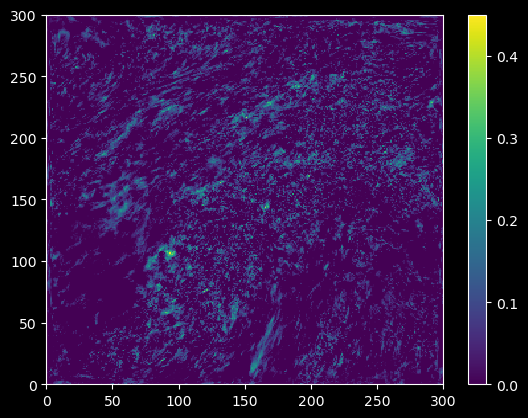

In [54]:
plt.pcolormesh(mi_scores.reshape(len(vars_list),300,300)[0])
plt.colorbar()